# Flattening and glacier gridpoint selection tests:

- the tests take too long inside of the OGGM framework and would need all the flattened datasets. Therefore it is done here:
    - We check if the climate is the same of the flattened and unflattened files,
        - we also check if GSWP3-W5E5 is equal to the flattened W5E5v2.0 in the common time period!
    - did we always select the nearest glacier gridpoints? (this was wrong for around 11900 glaciers in v2022.2, but now work in v2023.2 upwards)
- created test GSWP3-W5E5, ERA5 and ISIMIP3b files for pytest

**Currently updated to check if RGI6, RGI7C and RGI7G glacier gridpoints are correctly included**

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pandas as pd
import os
from oggm import utils, workflow, tasks, cfg
import logging 
cfg.initialize(logging_level='ERROR')

log = logging.getLogger(__name__)

log.workflow(f'Starting r')    


2025-12-11 18:55:24: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-12-11 18:55:24: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-12-11 18:55:24: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-12-11 18:55:25: __main__: Starting r


## Some checks because of longitude 0 issue 
(it is only an issue for two glaciers and they are really small, so we will only solve this in OGGM v17)

In [307]:
rgi_ids=['RGI60-11.03228']
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/ERA5/elev_bands/qc3/pcp1.6/match_geod_pergla'
cfg.PARAMS['prcp_fac'] = 1.6
cfg.PATHS['working_dir'] = utils.get_temp_dir()
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=160,
                                          prepro_base_url=base_url, prepro_rgi_version='62')

gdir = gdirs[0]
_dt = xr.open_dataset(gdir.get_filepath('climate_historical'))
lon = gdir.cenlon + 360 if gdir.cenlon < 0 else gdir.cenlon
lat = gdir.cenlat
print(gdir.rgi_id, lon, lat)
print('\n')
print('OGGMv1.4 ERA5 climate historical (wrong climate assigned):',_dt)


dg = xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.1/era5_monthly_prcp_1979-2019.nc')
res = float(dg.longitude[1] - dg.longitude[0])  # grid resolution
wrap_limit = 360 - res / 2
lon_sp = lon
if lon > wrap_limit:
    # we want to actually select longitude 0
    lon_sp = lon - 360
_dg_old = dg.sel(longitude=lon, latitude=lat, method='nearest')
_dg_sp = dg.sel(longitude=lon_sp, latitude=lat, method='nearest')
print('\n')
print('old selection method: ',_dg_old.longitude.values, _dg_old.latitude.values)
print('new selection method: ',_dg_sp.longitude.values, _dg_sp.latitude.values)

RGI60-11.03228 359.960316613 42.695419312


OGGMv1.4 ERA5 climate historical (wrong climate assigned): <xarray.Dataset> Size: 8kB
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    prcp     (time) float32 2kB ...
    temp     (time) float32 2kB ...
Attributes:
    ref_hgt:         1609.1440502108264
    ref_pix_lon:     -0.25
    ref_pix_lat:     42.75
    ref_pix_dis:     18220.98371756157
    climate_source:  ERA5
    hydro_yr_0:      1979
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model


old selection method:  359.75 42.75
new selection method:  0.0 42.75


In [293]:
dg = xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.1/era5_monthly_t2m_1979-2019.nc')
res = float(dg.longitude[1] - dg.longitude[0])  # grid resolution
wrap_limit = 360 - res / 2
lon_sp = lon
if lon > wrap_limit:
    lon_sp = lon - 360
_dg = dg.sel(longitude=lon_sp, latitude=lat, method='nearest')
print(lon_sp)
_dg

-0.03968338700002505


<xarray.Dataset> Size: 8kB
Dimensions:    (time: 492)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2019-12-01
    longitude  float32 4B 0.0
    latitude   float32 4B 42.75
Data variables:
    t2m        (time) float64 4kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-01-23 17:50:19 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [183]:
#RGI60-11.03228 	11 	11-02 	Taillon 		
cenlon = -0.039683 
lat = 42.695419

In [203]:
ds = xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_glacier_invariant_flat_v2025.11.25.nc')
_t = ds.where((ds.longitude.values==0) & (ds.latitude.values==42.75)).z.dropna(dim='points')
_t

<xarray.DataArray 'z' (points: 1)> Size: 4B
array([16626.475], dtype=float32)
Coordinates:
    latitude   (points) float64 8B 42.75
    longitude  (points) float64 8B 0.0
Dimensions without coordinates: points
Attributes: (12/33)
    GRIB_paramId:                             129
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               m**2 s**-2
    long_name:                                Geopotential
    units:                                    m**2 s**-2
    standard_name:                            geopotential
    GRIB_surface:                             0.0
    name:                                     ERA5 geopotential surface

In [210]:
### this apptoach works but currently not for an array of values
_lon_diff_abs = np.abs(_t.longitude - lon)
lon_diff = (360-_lon_diff_abs) if _lon_diff_abs>(360- _lon_diff_abs)  else _lon_diff_abs
c = lon_diff + (_t.latitude - lat)**2
_ds = _t.isel(points=np.argmin(c.data))
_ds.longitude

<xarray.DataArray 'longitude' ()> Size: 8B
array(0.)
Coordinates:
    latitude   float64 8B 42.75
    longitude  float64 8B 0.0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [207]:
## while this old approach does not work 
_lon_diff_abs = np.abs(_t.longitude - lon)
c = _lon_diff_abs + np.abs(_t.latitude - lat)
_ds = _t.isel(points=np.argmin(c.data))
_ds.longitude

<xarray.DataArray 'longitude' ()> Size: 8B
array(0.)
Coordinates:
    latitude   float64 8B 42.75
    longitude  float64 8B 0.0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [185]:
ds = xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_t2m_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc')
ds.where((ds.longitude.values==0) & (ds.latitude.values==42.75)).dropna(dim='points')

<xarray.Dataset> Size: 12kB
Dimensions:    (time: 1020, points: 1)
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-12-01
    latitude   (points) float64 8B 42.75
    longitude  (points) float64 8B 0.0
Dimensions without coordinates: points
Data variables:
    t2m        (time, points) float32 4kB 266.7 272.0 274.1 ... 277.9 272.9
Attributes:
    Conventions:               CF-1.7
    institution:               European Centre for Medium-Range Weather Forec...
    history:                   2025-11-03T16:12 GRIB to CDM+CF via cfgrib-0.9...
    postprocessing_date:       2025-12-01
    postprocessing_scientist:  lilian.schuster@uibk.ac.at
    version:                   v2025.11.25
    note:                      includes points from RGI6, RGI7C and RGI7G cen...

In [186]:
ds = xr.open_dataset('/home/www/oggm/climate/gswp3-w5e5/flattened/2025.11.25/monthly/gswp3-w5e5_glacier_invariant_flat_v2025.11.25.nc')

In [214]:
ds = xr.open_dataset('/home/www/oggm/climate/era5/daily/v1.0/era5_daily_t2m_1979-2018_flat.nc')
# Vectorized longitude wrap-around distance:
lon_diff = np.abs(ds.longitude - lon)
lon_diff = np.minimum(lon_diff, 360 - lon_diff)
# Flattened ERA5
c = lon_diff**2 + (ds.latitude - lat)**2
_ds = ds.isel(points=np.argmin(c.data))
_ds.longitude

<xarray.DataArray 'longitude' ()> Size: 8B
array(0.)
Coordinates:
    latitude   float64 8B 42.75
    longitude  float64 8B 0.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [200]:
_lon_diff_abs = np.abs(ds.longitude - lon)
lon_diff = (360-_lon_diff_abs) if _lon_diff_abs>(360- _lon_diff_abs)  else _lon_diff_abs
c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
_ds = ds.isel(points=np.argmin(c.data))
_ds.longitude

In [188]:
ds = xr.open_dataset('/home/www/oggm/climate/era5-land/monthly/v1.0/era5_land_monthly_prcp_1981-2018_flat.nc')

In [189]:
lon = cenlon + 360 if cenlon < 0 else cenlon

# Flattened ERA5
c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
_ds = ds.isel(points=np.argmin(c.data))
_ds.longitude

<xarray.DataArray 'longitude' ()> Size: 8B
array(359.899994)
Coordinates:
    latitude   float64 8B 42.7
    longitude  float64 8B 359.9

In [196]:
np.abs((ds.longitude - lon)).max()

<xarray.DataArray 'longitude' ()> Size: 8B
array(359.960317)

In [167]:
np.abs(ds.longitude - lon).min()

<xarray.DataArray 'longitude' ()> Size: 8B
array(0.192544)

In [147]:
((ds.longitude - lon)**2).argmin()

<xarray.DataArray 'longitude' ()> Size: 8B
array(8176)

In [154]:
ds.isel(points=np.abs(ds.longitude - lon).argmin()).longitude.values

array(359.75)

In [155]:
ds.isel(points=((ds.longitude - lon)**2).argmin()).longitude.values

array(359.75)

In [126]:
_t = xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_tp_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc')
_t.where((_t.longitude.values==0) & (_t.latitude.values==42.75)).tp.dropna(dim='points')

<xarray.DataArray 'tp' (time: 1020, points: 1)> Size: 4kB
array([[0.00316429],
       [0.00218296],
       [0.00263691],
       ...,
       [0.00722885],
       [0.00223827],
       [0.00372887]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-12-01T0...
    latitude   (points) float64 8B 42.75
    longitude  (points) float64 8B 0.0
Dimensions without coordinates: points
Attributes:
    long_name:      Total precipitation
    units:          m
    standard_name:  unknown

In [123]:
_t = xr.open_dataset('/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_t2m_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc')
_t.where((_t.longitude.values==0) & (_t.latitude.values==42.75)).t2m.dropna(dim='points')

<xarray.Dataset> Size: 12kB
Dimensions:    (time: 1020, points: 1)
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-12-01
    latitude   (points) float64 8B 42.75
    longitude  (points) float64 8B 0.0
Dimensions without coordinates: points
Data variables:
    t2m        (time, points) float32 4kB 266.7 272.0 274.1 ... 277.9 272.9
Attributes:
    Conventions:               CF-1.7
    institution:               European Centre for Medium-Range Weather Forec...
    history:                   2025-11-03T16:12 GRIB to CDM+CF via cfgrib-0.9...
    postprocessing_date:       2025-12-01
    postprocessing_scientist:  lilian.schuster@uibk.ac.at
    version:                   v2025.11.25
    note:                      includes points from RGI6, RGI7C and RGI7G cen...

**Let's get all glacier longitude / latitude to check later the distance to the nearest gridpoints:**

In [38]:
# get the dataset where coordinates of glaciers are stored
frgi_6 = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
odf_6 = pd.read_hdf(frgi_6, index_col=0)
odf_6['coords'] = [(lon,lat) for lon,lat in zip(odf_6['CenLon'],odf_6['CenLat'])]

#### glacier complexes
frgi_7C = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/RGI2000-v7.0-C-global-attributes.csv')
odf_7C = pd.read_csv(frgi_7C, index_col=0)
odf_7C['coords'] = [(lon,lat) for lon,lat in zip(odf_7C['cenlon'],odf_7C['cenlat'])]
#### glaciers 
frgi_7G = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/RGI2000-v7.0-G-global-attributes.csv')
odf_7G = pd.read_csv(frgi_7G, index_col=0)
odf_7G['coords'] = [(lon,lat) for lon,lat in zip(odf_7G['cenlon'],odf_7G['cenlat'])]

# this includes now all cen lon/latitudes from the three versions, there may be "duplicates", but that just means that the long test takes a bit longer 
odf = pd.concat([odf_6, odf_7C, odf_7G]) 
odf['coords']

RGI60-01.00001                                  (-146.823, 63.689)
RGI60-01.00002                                  (-146.668, 63.404)
RGI60-01.00003                                   (-146.08, 63.376)
RGI60-01.00004                                   (-146.12, 63.381)
RGI60-01.00005                                  (-147.057, 63.551)
                                            ...                   
RGI2000-v7.0-G-19-02738          (-3.254146774869713, -71.1422615)
RGI2000-v7.0-G-19-02739           (1.161198746966389, -70.2348605)
RGI2000-v7.0-G-19-02740    (2.039157613598415, -70.63090700000001)
RGI2000-v7.0-G-19-02741           (2.929238357467267, -70.5055405)
RGI2000-v7.0-G-19-02742    (4.329046288919026, -70.37280200000001)
Name: coords, Length: 683902, dtype: object

### We start by the ultimative test that should work at the end (after reproducing preprocessing levels 3)
- todo: once RGI7 gdirs are out, need to repeat this with these ones!!!

In [ ]:
import glob
sum_paths = ['/home/www/oggm//gdirs/oggm_v1.4/L3-L5_files/ERA5/elev_bands/qc3/pcp1.6/match_geod_pergla/RGI62/b_160/L3/summary/']
for sum_path in sum_paths:
    if 'ERA5' in sum_path:
        res = 0.25/2
    else:
        res = 0.25
    all_files = glob.glob(f'{sum_path}/glacier_statistics_*.csv')
    
    li = []
    for filename in all_files:
        odf_prepro = pd.read_csv(filename, low_memory=False)
        li.append(odf_prepro)
    
    odf_prepro = pd.concat(li, axis=0, ignore_index=True)
    condi1 = np.abs(odf_prepro.cenlon - odf_prepro.baseline_climate_ref_pix_lon)>res
    condi2 = np.abs(odf_prepro.cenlat - odf_prepro.baseline_climate_ref_pix_lat)>res
    try:
        assert len(odf_prepro.loc[condi1 | condi2]) == 0
    except:
        _t =odf_prepro.loc[condi1 | condi2]
        _t.loc[_t.baseline_climate_ref_pix_lon==180, 'baseline_climate_ref_pix_lon'] = -180
        condi1 = np.abs(_t.cenlon - _t.baseline_climate_ref_pix_lon)>res
        condi2 = np.abs(_t.cenlat - _t.baseline_climate_ref_pix_lat)>res
        assert len(_t.loc[condi1 | condi2]) == 0


In [311]:
odf_prepro.columns

Index(['rgi_id', 'rgi_region', 'rgi_subregion', 'name', 'cenlon', 'cenlat',
       'rgi_area_km2', 'rgi_year', 'glacier_type', 'terminus_type',
       'is_tidewater', 'status', 'inv_volume_km3', 'vas_volume_km3',
       'inv_volume_bsl_km3', 'inv_volume_bwl_km3', 'dem_source',
       'flowline_type', 'ref_hgt_qc_diff', 'apparent_mb_from_any_mb_residual',
       'inversion_glen_a', 'inversion_fs', 'error_task', 'error_msg',
       'dem_mean_elev', 'dem_med_elev', 'dem_min_elev', 'dem_max_elev',
       'dem_max_elev_on_ext', 'dem_min_elev_on_ext',
       'dem_perc_area_above_max_elev_on_ext', 'terminus_lon', 'terminus_lat',
       'main_flowline_length', 'inv_flowline_glacier_area',
       'flowline_mean_elev', 'flowline_max_elev', 'flowline_min_elev',
       'flowline_avg_slope', 'flowline_avg_width', 'flowline_last_width',
       'flowline_last_5_widths', 't_star', 'mu_star_glacierwide',
       'mu_star_flowline_avg', 'mu_star_allsame', 'mb_bias',
       'ref_hgt_calib_diff', 'dem_need

In [ ]:
_t.loc[condi1 | condi2][['rgi_id','cenlon','cenlat','baseline_climate_ref_pix_lon','rgi_area_km2', 'inv_volume_km3']] # this here should normally be 0

In [312]:
import glob
sum_paths = ['/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/W5E5/per_glacier_spinup/RGI62/b_160/L3/summary',
             '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/W5E5/regional_spinup/RGI62/b_160/L3/summary/',
            '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup/RGI62/b_160/L5/summary/',
             '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/RGI62/b_160/L3/summary/']

for sum_path in sum_paths:
    if 'ERA5' in sum_path:
        res = 0.25/2
    else:
        res = 0.25
    all_files = glob.glob(f'{sum_path}/glacier_statistics_*.csv')
    
    li = []
    for filename in all_files:
        odf_prepro = pd.read_csv(filename, low_memory=False)
        li.append(odf_prepro)
    
    odf_prepro = pd.concat(li, axis=0, ignore_index=True)
    condi1 = np.abs(odf_prepro.cenlon - odf_prepro.baseline_climate_ref_pix_lon)>res
    condi2 = np.abs(odf_prepro.cenlat - odf_prepro.baseline_climate_ref_pix_lat)>res
    try:
        assert len(odf_prepro.loc[condi1 | condi2]) == 0
    except:
        _t =odf_prepro.loc[condi1 | condi2]
        _t.loc[_t.baseline_climate_ref_pix_lon==180, 'baseline_climate_ref_pix_lon'] = -180
        condi1 = np.abs(_t.cenlon - _t.baseline_climate_ref_pix_lon)>res
        condi2 = np.abs(_t.cenlat - _t.baseline_climate_ref_pix_lat)>res
        assert len(_t.loc[condi1 | condi2]) == 0


AssertionError: 

In [118]:
odf.loc['RGI60-11.00897'].Area

8.036

In [219]:
_t.columns

Index(['rgi_id', 'rgi_region', 'rgi_subregion', 'name', 'cenlon', 'cenlat',
       'rgi_area_km2', 'rgi_year', 'glacier_type', 'terminus_type',
       'is_tidewater', 'status', 'grid_dx', 'grid_nx', 'grid_ny',
       'geometry_type', 'geometry_is_valid', 'geometry_area_km2',
       'inv_volume_km3', 'vas_volume_km3', 'inv_volume_bsl_km3',
       'inv_volume_bwl_km3', 'dem_source', 'flowline_type',
       'apparent_mb_from_any_mb_residual', 'inversion_glen_a', 'inversion_fs',
       'error_task', 'error_msg', 'dem_mean_elev', 'dem_med_elev',
       'dem_min_elev', 'dem_max_elev', 'dem_max_elev_on_ext',
       'dem_min_elev_on_ext', 'dem_perc_area_above_max_elev_on_ext',
       'terminus_lon', 'terminus_lat', 'main_flowline_length',
       'inv_flowline_glacier_area', 'flowline_mean_elev', 'flowline_max_elev',
       'flowline_min_elev', 'flowline_avg_slope', 'flowline_avg_width',
       'flowline_last_width', 'flowline_last_5_widths',
       'baseline_climate_source', 'baseline_yr_0', '

In [313]:
_t.loc[condi1 | condi2][['name','rgi_id','cenlon','cenlat','baseline_climate_ref_pix_lon','rgi_area_km2', 'inv_volume_km3']] # this here should normally be 0

name          rgi_id    cenlon     cenlat  \
211310    Taillon  RGI60-11.03228 -0.039683  42.695419   
211311  Gabietous  RGI60-11.03229 -0.057456  42.695129   

        baseline_climate_ref_pix_lon  rgi_area_km2  inv_volume_km3  
211310                         -0.25         0.083        0.001641  
211311                         -0.25         0.087        0.001485

In [217]:
print('amount of glaciers that do not take the nearest climate gridpoint:')
print(len(_t.loc[condi1 | condi2]))
_t.loc[condi1 | condi2]#.groupby('rgi_region').count()

amount of glaciers that do not take the nearest climate gridpoint:
2


rgi_id  rgi_region rgi_subregion       name    cenlon  \
211310  RGI60-11.03228          11         11-02    Taillon -0.039683   
211311  RGI60-11.03229          11         11-02  Gabietous -0.057456   

           cenlat  rgi_area_km2  rgi_year glacier_type     terminus_type  ...  \
211310  42.695419         0.083      2011      Glacier  Land-terminating  ...   
211311  42.695129         0.087      2011      Glacier  Land-terminating  ...   

             reference_period temp_default_gradient  temp_all_solid  \
211310  2000-01-01_2020-01-01               -0.0065             0.0   
211311  2000-01-01_2020-01-01               -0.0065             0.0   

        temp_all_liq  temp_melt dem_needed_interpolation  dem_invalid_perc  \
211310           2.0       -1.0                      NaN               NaN   
211311           2.0       -1.0                      NaN               NaN   

        dem_needed_extrapolation  dem_extrapol_perc  dem_invalid_perc_in_mask  
211310                       NaN                NaN                       NaN  
211311                       NaN                NaN                       NaN  

[2 rows x 69 columns]

### The same can be tested in a more complicated way for the different flattened files:
- a short version is inside `test_shop.test_glacier_gridpoint_selection`

In [230]:
def test_glacier_gridpoint_selection(path_l, short = True, print_stuff=False, include_rgi7_points=True, res = 0.5):

    #### res=0.5: for W5E5 and ISIMIP3b have 0.5° resolution, for ERA5 it should be 0.25
    for p in path_l:
        if 'inv' not in p:
            with xr.open_dataset(p) as dt:
                dt = dt.isel(time=0) # we only need the lat/lon anyways
        else:
            dt = xr.open_dataset(p)
        if short:
            # select three glaciers where two failed in the
            # previous gswp3_w5e5 version
            coords = [(10.7584, 46.8003),  # HEF
                          (-70.8931, -72.4474),  # RGI60-19.00124
                          (51.495, 30.9010),  # RGI60-12.01691
                          (-0.039683, 42.695419 ),   # RGI60-11.03228 glacier near 0 longitude 
                          (-179.915527, 66.276108), # RGI60-10.05049 	(near -180 longitude)
                     ]
            if include_rgi7_points:
                coords2 = [
                      ( -141.670274, 69.166921), # in RGI7C, not in RGI6
                      (-66.855668, -67.535551) # only in RGI7G, not in RGI6 or in RGI 7C
                          ]
                coords = coords + coords2
        else:
            if include_rgi7_points:
                coords = odf['coords']                
            else:
                coords = odf_6['coords']
        for coord in coords:
            lon, lat = coord
            if lon <0:
                lon = lon + 360
            # get the distances to the glacier coordinate
            try:
                lon_diff = np.abs(dt.longitude - lon)
                # longitude 0 equals to 360 ... 
                lon_diff = np.minimum(lon_diff, 360 - lon_diff)
                c = ((lon_diff) ** 2 + (dt.latitude - lat) ** 2)**0.5
                _lon = 'longitude'
                _lat = 'latitude'
            except:
                lon_diff = np.abs(dt.lon - lon)
                # longitude 0 equals to 360 ... 
                lon_diff = np.minimum(lon_diff, 360 - lon_diff)
                c = ((lon_diff) ** 2 + (dt.lat - lat) ** 2)**0.5
                _lon = 'lon'
                _lat = 'lat'

            # select the nearest climate point from the flattened
            # glacier gridpoint
            if 'inv' in p:
                _c = c.to_dataframe('distance').sort_values('distance')
                lat_near, lon_near, dist = _c[[_lat,_lon, 'distance']].iloc[0]
                # for a randomly chosen gridpoint, the next climate gridpoint is far away
                # for glacier gridpoints the next gridpoint should be the nearest
                # (GSWP3-W5E5 resolution is 0.5°)
                if print_stuff:
                    print(p, dist, lat_near, lat, lon_near, lon)
                assert dist <= ((res/2) ** 2 + (res/2) ** 2) ** 0.5
                assert np.abs(lat_near - lat) <= res/2
                _lon_diff = np.abs(lon_near - lon)
                _lon_diff = np.minimum(_lon_diff, 360 - _lon_diff)
                assert _lon_diff <= res/2
            else:
                dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
                if print_stuff:
                    print(p, dist, lon, lat)
                try:
                    assert dist <= ((res/2) ** 2 + (res/2) ** 2) ** 0.5
                except:
                    print(p, dist, lon, lat, c)
                    assert dist <= ((res/2) ** 2 + (res/2) ** 2) ** 0.5


In [225]:
### for that to run need the latest OGGM 
# select directly the OGGM w5e5 files

short = True
from oggm.shop import w5e5
d = 'GSWP3_W5E5'

path_l = []
for var in ['inv','tmp', 'temp_std', 'prcp']:
    path_l.append(w5e5.get_gswp3_w5e5_file(d, var))
    
### TODO--> once OGGM is updated, change this to include_rgi7_points=True
test_glacier_gridpoint_selection(path_l, short=short, print_stuff=True, include_rgi7_points=False)


/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.05099656851200873 46.75 46.8003 10.75 10.7584
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.2438121613045622 -72.25 -72.4474 289.25 289.1069
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.28779506597577154 30.75 30.901 51.25 51.495
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.2172839755941274 42.75 42.695419 359.75 359.960317
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.16757331348695942 66.25 66.276108 180.25 180.084473
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/

- w5e5 files:

In [226]:
w5e5_files = []
#folder_w5e5 = www_lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc
os.listdir('/home/www/lschuster/w5e5v2.0/flattened/2023.2')

w5e5_files = []
w5e5_files_l = []
w5e5_files.append('/home/www/lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc')
w5e5_files_l.append('/home/www/lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc')

folder_p = '/home/www/lschuster/w5e5v2.0/flattened/2023.2/monthly/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        w5e5_files.append(folder_p+p)
# add the last one inside for the long test
w5e5_files_l.append(folder_p + os.listdir(folder_p)[1])

folder_p = '/home/www/lschuster/w5e5v2.0/flattened/2023.2/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        w5e5_files.append(folder_p+p)
# add the last one inside for the long test
w5e5_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(w5e5_files, short = True, print_stuff=False, include_rgi7_points=False)


In [ ]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(w5e5_files_l, short = False, include_rgi7_points=False)

- isimip3b (including secondary files)

In [228]:
isimip3b_files = []
isimip3b_files_l = []
#invariant files are in monthly/daily
#isimip3b_files.append('/home/www/lschuster/isimip3b_flat/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files_l.append('/home/www/lschuster/isimip3b_flat/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files.append('/home/www/oggm/cmip6/isimip3b/flat/2025.11/daily/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files_l.append('/home/www/oggm/cmip6/isimip3b/flat/2025.11/daily/isimip3b_glacier_invariant_flat.nc')

folder_p = '/home/www/oggm/cmip6/isimip3b/flat/2025.11.25/monthly/'
for p in os.listdir(folder_p):
    isimip3b_files.append(folder_p+p)
# add the last one inside for the long test
isimip3b_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3b_files, short = True, print_stuff=False,
                                 include_rgi7_points=True)

In [44]:
# do the long test only for the last file in total
test_glacier_gridpoint_selection(isimip3b_files_l, short = False)
print('worked')

/home/www/oggm/cmip6/isimip3b/flat/2025.11.25/monthly/cesm2-waccm_r1i1p1f1_w5e5_ssp126_tasAdjust_global_monthly_flat_glaciers_v2025.11.25.nc
worked


In [46]:
###daily files
isimip3b_files = []
isimip3b_files_l = []
folder_p = '/home/www/oggm/cmip6/isimip3b/flat/2025.11.25/daily/'
#folder_p = '/home/www/lschuster/isimip3b_flat/flat/2025.11.25/daily/'

for p in os.listdir(folder_p):
    isimip3b_files.append(folder_p+p)
# add the last one inside for the long test
isimip3b_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3b_files, short = True, print_stuff=False)


In [ ]:
# do the long test only for one file in total
test_glacier_gridpoint_selection(isimip3b_files_l, short = False)
print('worked')

- isimip3a

In [151]:
isimip3a_files = []
isimip3a_files_l = []
folder_p = '/home/www/oggm/climate/gswp3-w5e5/flattened/2025.11.25/monthly/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        isimip3a_files.append(folder_p+p)
# add the last one inside for the long test
isimip3a_files_l.append(isimip3a_files[-1])

folder_p = '/home/www/oggm/climate/gswp3-w5e5/flattened/2025.11.25/daily/'
for p in os.listdir(folder_p):
    isimip3a_files.append(folder_p+p)
# add the last one inside for the long test
isimip3a_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3a_files, short = True, print_stuff=False)


In [94]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(isimip3a_files_l, short = False)

- era5 monthly/daily

In [238]:
era5_files = []
era5_files_l = []

folder_p = '/home/www/oggm/climate/era5/monthly/v1.2/flattened/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        era5_files.append(folder_p+p)
# add the last one inside for the long test
era5_files_l = era5_files[-2:].copy()
folder_p = '/home/www/oggm/climate/era5/daily/v1.2/flattened/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        era5_files.append(folder_p+p)
# add the last one inside for the long test
era5_files_l.append(era5_files[-2])
era5_files_l.append(era5_files[-1])
print(era5_files)
test_glacier_gridpoint_selection(era5_files, short = True, print_stuff=False, res=0.25)



['/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_tp_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc', '/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_t2m_global_monthly_1940_2024_flat_glaciers_v2025.11.25.nc', '/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_glacier_invariant_flat_v2025.11.25.nc', '/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_glacier_invariant_flat_v2025.11.25.nc', '/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_t2m_global_daily_1940_2024_flat_glaciers_v2025.11.25.nc', '/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_tp_global_daily_1940_2024_flat_glaciers_v2025.11.25.nc']


In [238]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(era5_files_l, short = False, res=0.25)


KeyboardInterrupt



KeyboardInterrupt: 

- era5 land (these are just older flattened files, where all gridpoints remain, but it is probably still good to double-check)

In [ ]:
era5land_files = []
era5land_files_l = []

#era5_files.append('/home/www/oggm/climate/wip/era5_daily_lily/flattened/2025.11/gswp3-w5e5_glacier_invariant_flat.nc')
#era5_files_l.append('/home/www/oggm/climate/wip/era5_daily_lily/flattened/2025.11/gswp3-w5e5_glacier_invariant_flat.nc')

folder_p = '/home/www/oggm/climate/era5-land/monthly/v1.0/'
for p in os.listdir(folder_p):
    if ('.nc' in p) and ('flat' in p):
        era5land_files.append(folder_p+p)
# add the last one inside for the long test
era5land_files_l.append(era5land_files[-1])

# this can't work for HMA ;-)
#folder_p = '/home/www/oggm/climate/era5-land/monthly/vhma/'
#for p in os.listdir(folder_p):
#    if '.nc' in p:
#        era5land_files.append(folder_p+p)
# add the last one inside for the long test
#era5land_files_l.append(era5land_files[-2])
print(era5land_files)
test_glacier_gridpoint_selection(era5land_files, short = True,
                                 print_stuff=False, res=0.1) # resolution for ERA5-land is 0.1°



In [ ]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(era5land_files_l, short = False, res=0.1)

## Is the climate the same of the flattened and unflattened files? TODO: update to 2025.11.25

- gswp3-w5e5 / isimip3a : 

In [83]:
# check for every glacier gridpoint if the correct climate dataset 
# was used by comparing it to the unflattened file:
# this takes some time (we only do this for the monthly files like that, it would take too long for the daily files)

# path_clim = '/home/www/oggm/climate/gswp3-w5e5/'
for version in ['2022_missing_points', '2023.2']:
    for var in ['pr', 'tas']:
        fp = f'/home/www/lschuster/isimip3a/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc'
        ds_flattened = xr.open_dataset(fp)
        fp_unflat = '/home/www/lschuster/isimip3a/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019.nc'.format(var)
        ds_unflattened = xr.open_dataset(fp_unflat)

        for p in ds_flattened.points:
            # get the point
            ds_flattened_sel = ds_flattened.sel(points=p)
            # select longitude, latitude and tas of that point
            lon_p = ds_flattened_sel.longitude
            lat_p = ds_flattened_sel.latitude
            var_p = ds_flattened_sel[var]
            # select the same gridpoint from the unflattened file
            # the unflattened file is in -180, 180
            if lon_p >=180:
                lon_p = lon_p-360
            # check if the unflattened and the flattened file have the same climate
            # data inside
            np.testing.assert_allclose(var_p.values,
                                       ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


In [ ]:
# the same test for the data directly in www/oggm -> they should be the same:
path_clim = '/home/www/oggm/climate/gswp3-w5e5/'

for var in ['pr', 'tas']:
    fp = path_clim + 'flattened/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019_flat_glaciers.nc'.format(var)
    ds_flattened = xr.open_dataset(fp)
    fp_unflat = path_clim + 'unflattened/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019.nc'.format(var)
    ds_unflattened = xr.open_dataset(fp_unflat)
    
    # check for every glacier gridpoint if the correct climate dataset 
    # was used by comparing it to the unflattened file:
    for p in ds_flattened.points:
        # get the point
        ds_flattened_sel = ds_flattened.sel(points=p)
        # select longitude, latitude and tas of that point
        lon_p = ds_flattened_sel.longitude
        lat_p = ds_flattened_sel.latitude
        var_p = ds_flattened_sel[var]
        # select the same gridpoint from the unflattened file
        # the unflattened file is in -180, 180
        if lon_p >=180:
            lon_p = lon_p-360
        # check if the unflattened and the flattened file have the same climate
        # data inside
        np.testing.assert_allclose(var_p.values,
                                   ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


- w5e5v2.0: check if the flattened file is the same as the gswps-w5e5 file over the common period

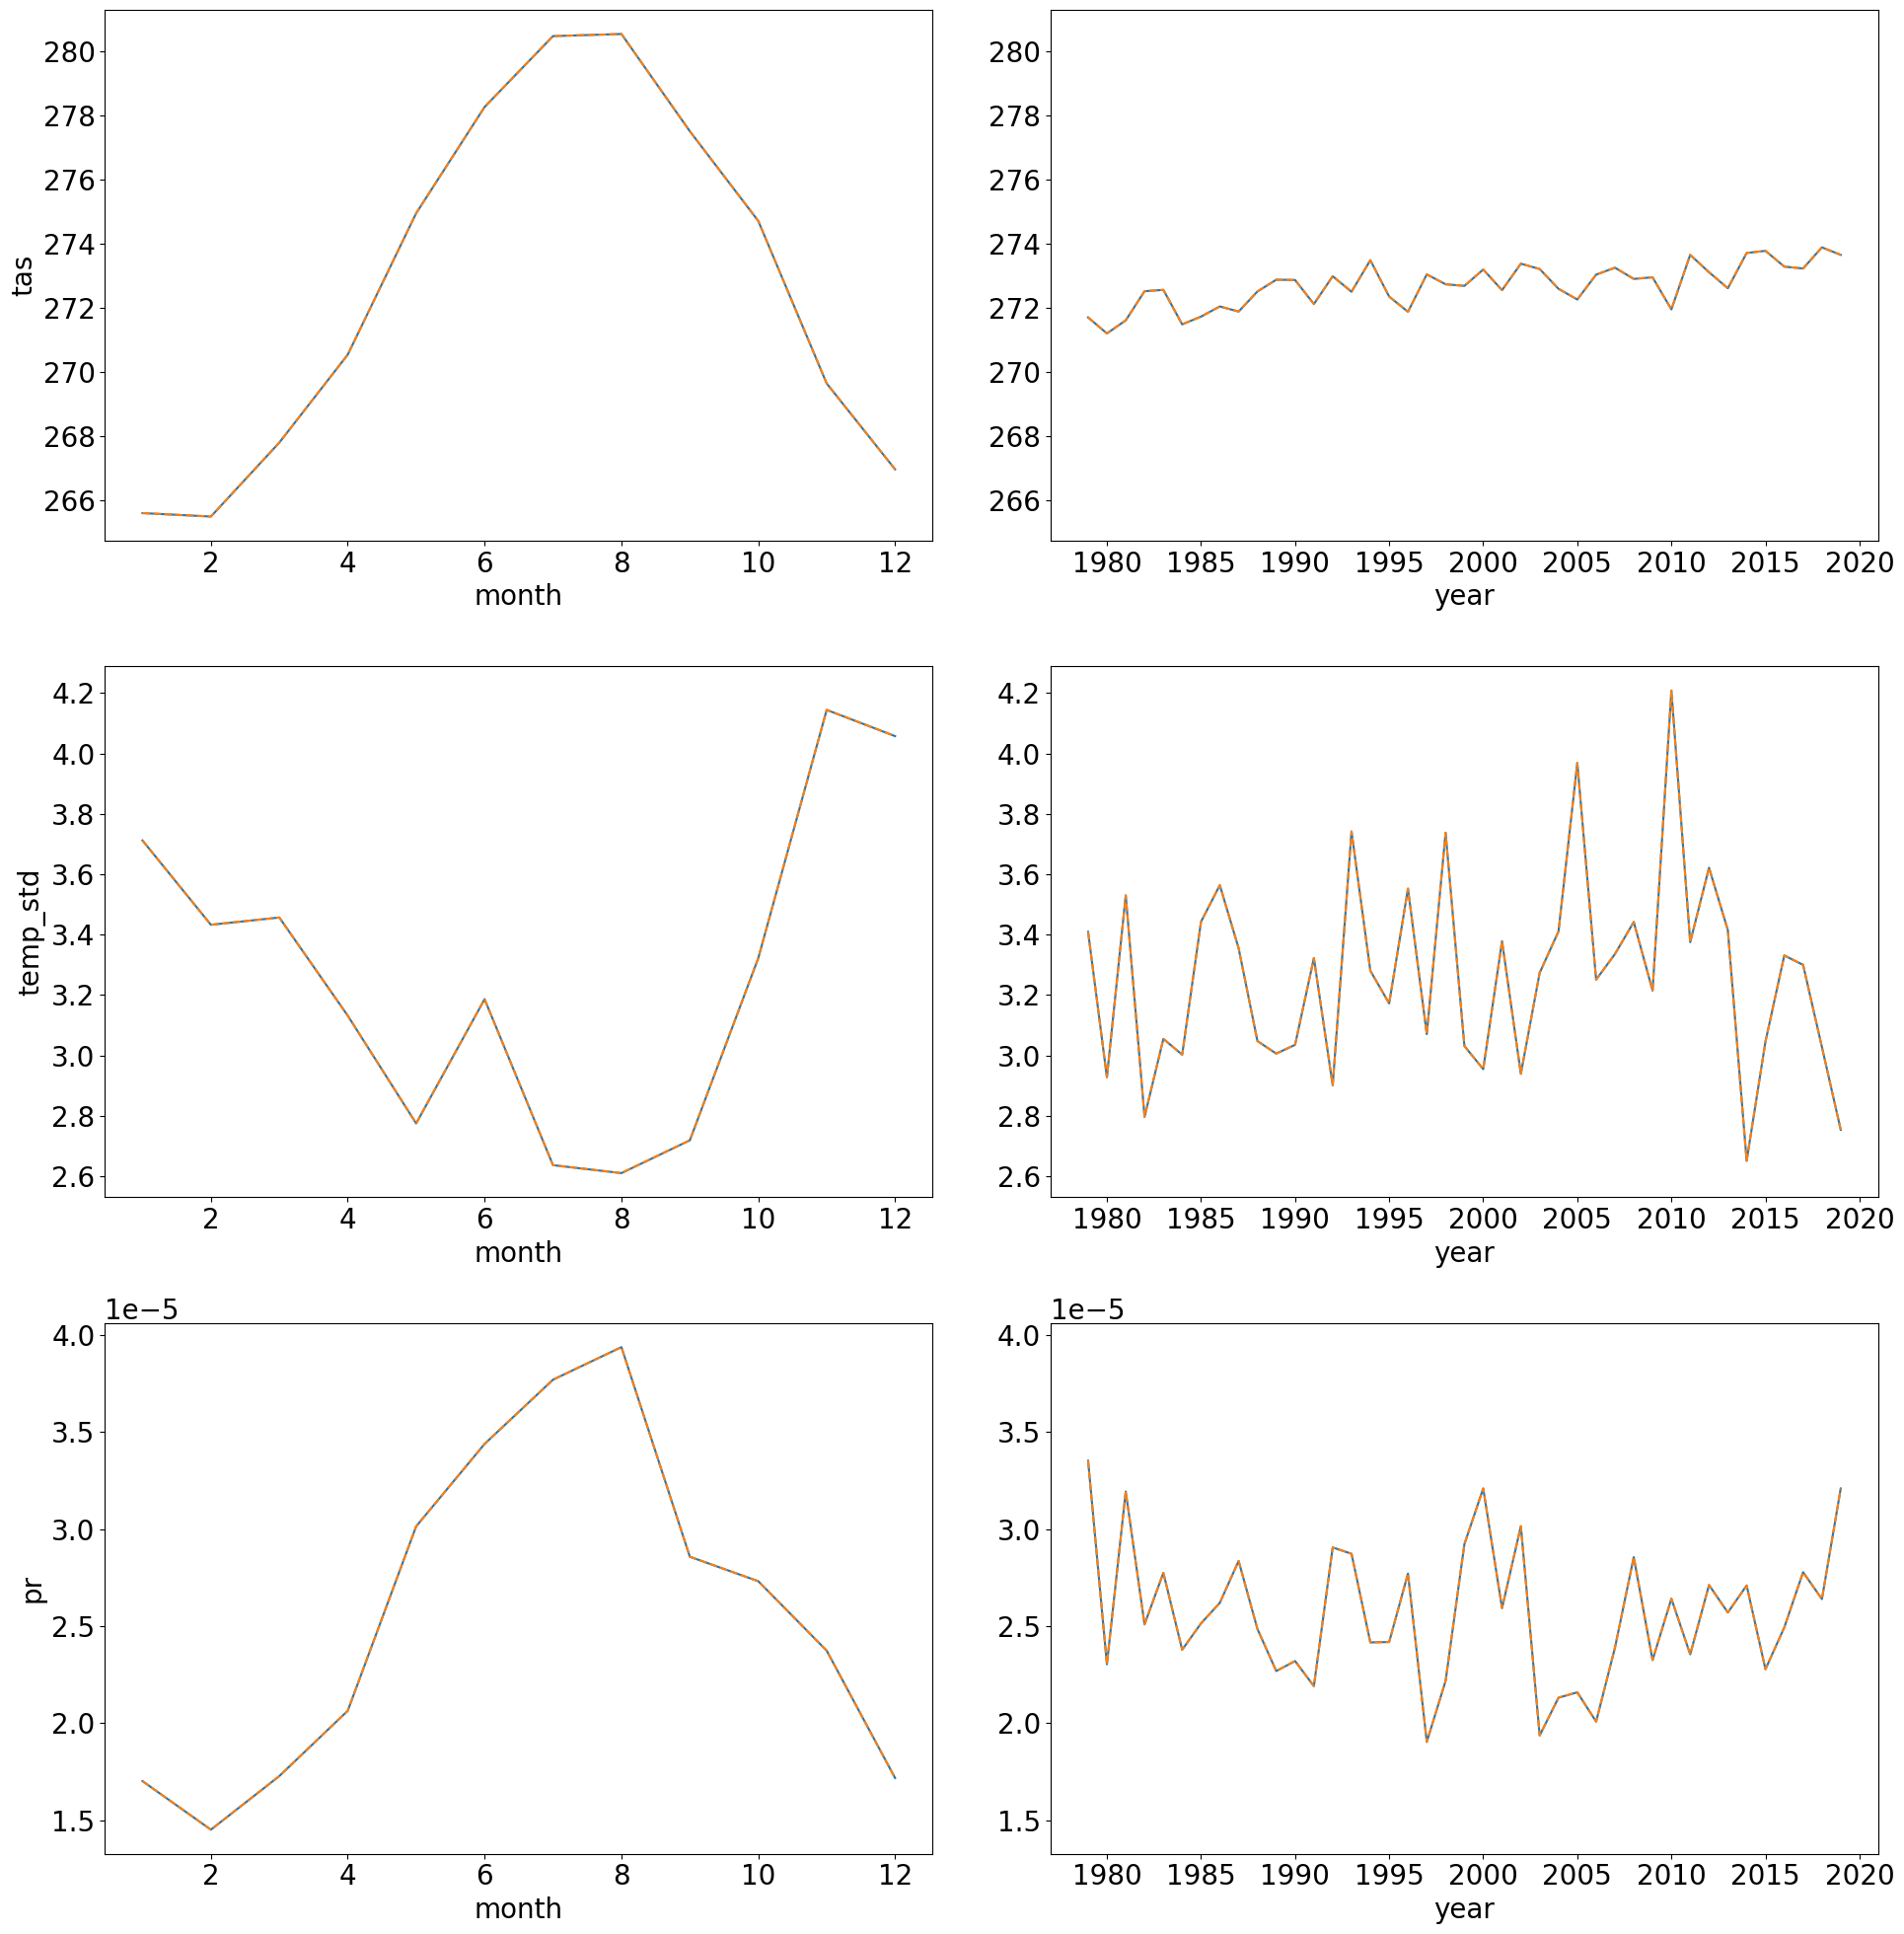

In [99]:
plt.rcParams['font.size'] = 20
j = 0
plt.figure(figsize=(20,20))
#plt.rcsize(20)
for var in ['tas', 'temp_std', 'pr']:
    if var == 'temp_std':
        var_w5e5 = 'tas_std'
    else:
        var_w5e5 = var
    for version in  ['2023.2']: #['2022_missing_points',
        
        if version == '2022_missing_points':
            path_w5e5 = f'/home/www/lschuster/w5e5v2.0/flattened/monthly/w5e5v2.0_{var_w5e5}_global_monthly_flat_glaciers_1979_2019.nc'
            pathi = f'/home/www/oggm/climate/gswp3-w5e5/flattened/monthly'

        else:
            path_w5e5 = f'/home/www/lschuster/w5e5v2.0/flattened/{version}/monthly/w5e5v2.0_{var_w5e5}_global_monthly_flat_glaciers_1979_2019.nc'
            pathi = f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly'

        ds_w5e5 = xr.open_dataset(path_w5e5)
    
        ds_gswp3_w5e5 = xr.open_dataset(pathi+'/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019_flat_glaciers.nc'.format(var))
        # let's only look at the common time period!!!
        ds_gswp3_w5e5 = ds_gswp3_w5e5.sel(time=ds_w5e5.time)

        # this here is the main test, for all months and for all gridpoints, check if they coincide:
        # yes, they do!!!
        if var !='pr':
            np.testing.assert_allclose(ds_w5e5[var_w5e5], ds_gswp3_w5e5[var_w5e5], rtol=1e-6)
        else:
            # prcp is in daily mean values (kg m-2 s-1) and has much smaller values than temperatures, so datasets should be more similar
            np.testing.assert_allclose(ds_w5e5[var_w5e5], ds_gswp3_w5e5[var_w5e5], rtol=1e-9)


        # visual test just for HEF:
        lon, lat = (10.7584, 46.8003)
        c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
        plt.subplot(3,2,j+1)
        plt.plot(np.arange(1,13,1), ds_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.month').mean())
        plt.plot(np.arange(1,13,1), ds_gswp3_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.month').mean(),ls='--')
        j+=1
        plt.ylabel(var)
        ax=plt.gca()
        plt.xlabel('month')

        plt.subplot(3,2,j+1, sharey=ax)
        plt.plot(np.arange(1979,2020,1), ds_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.year').mean())
        plt.plot(np.arange(1979,2020,1), ds_gswp3_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.year').mean(), ls='--')
        j+=1
    plt.xlabel('year')
    
plt.tight_layout()

In [ ]:
# check for every glacier gridpoint if the correct climate dataset 
# was used by comparing it to the unflattened file:
# this takes some time (we only do this for the monthly files like that, it would take too long for the daily files)

# path_clim = '/home/www/oggm/climate/gswp3-w5e5/'
# don't run this ... 

run = False
if run:
    for version in ['2022_missing_points', '2023.2']:
        for var in ['pr', 'tas']:
            if version == '2022_missing_points':
                fp = f'/home/www/lschuster/w5e5v2.0/flattened/monthly/w5e5v2.0_{var}_global_monthly_flat_glaciers_1979_2019.nc'
            else:
                fp = f'/home/www/lschuster/w5e5v2.0/flattened/{version}/monthly/w5e5v2.0_{var}_global_monthly_flat_glaciers_1979_2019_.nc'
            ds_flattened = xr.open_dataset(fp)
            fp_unflat = f'/home/www/lschuster/w5e5v2.0/_script/{var}_W5E5v2.0_*.nc'
            with xr.open_mfdataset(fp_unflat) as ds_unflattened:
                ds_unflattened = ds_unflattened.resample(time='MS').mean()
            for p in ds_flattened.points[:100]:
                # get the point
                ds_flattened_sel = ds_flattened.sel(points=p)
                # select longitude, latitude and tas of that point
                lon_p = ds_flattened_sel.longitude.isel(time=0)
                lat_p = ds_flattened_sel.latitude.isel(time=0)
                var_p = ds_flattened_sel[var]
                # select the same gridpoint from the unflattened file
                # the unflattened file is in -180, 180
                if lon_p >=180:
                    lon_p = lon_p-360
                # check if the unflattened and the flattened file have the same climate
                # data inside
                np.testing.assert_allclose(var_p.values,
                                           ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


## Create climate test files:
- this is for pytest in order that during the tests only a small part of the climate datasets are downloaded (just the nearest 4 points of HEF, of one glacier from RGI19 and two glaciers from only RGI7)!
- but these test files can not really be used to check if the right glacier gridpoints are selected, for that we use just the entire `inv` file which quite small (~100kb)

#### newer test files for 2025.11.25

In [5]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

lon3, lat3 = ( -141.670274+360, 69.166921) # in RGI7C, not in RGI6

lon4, lat4 = (-66.855668+360, -67.535551) # only in RGI7G, not in RGI6 or in RGI 7C

oggm_v17 = False
if oggm_v17:
    # we will only implement these changes in oggm_v17, so let's only include that glacier in that version
    lon5, lat5 =   (-0.039683+360, 42.695419 ) # RGI60-11.03228 also check glacier near longitude 0 
else:
    lon5, lat5 = (lon,lat)
lon6, lat6 =   (-179.915527, 66.276108) # RGI60-10.05049 	(near -180 longitude)

In [6]:
def abs_lon_diff_func(lon1, lon2):
    lon_diff = np.abs(lon1 - lon2)
    # longitude 0 equals to 360 ... 
    lon_diff = np.minimum(lon_diff, 360 - lon_diff)
    return lon_diff
assert abs_lon_diff_func(360,0)==0
assert abs_lon_diff_func(180,0) ==180

- GSWP3-W5E5

In [7]:
test_clim_path = '/home/www/oggm/test_climate/gswp3-w5e5'
for version in ['2025.11.25']:
    v = f'_v{version}'
    for var in ['inv','tas', 'temp_std', 'pr']:
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat{v}.nc')
            # we just take the entire invariant file inside because it does not make a big storage difference
            # same invariant file for both, monthly and daily
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat{v}.nc')
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/daily/gswp3-w5e5_glacier_invariant_flat{v}.nc')
        else:
            ds = xr.open_dataset(f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers{v}.nc')
            if var != 'temp_std':
                ds_d = xr.open_dataset(f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/daily/gswp3-w5e5_obsclim_{var}_global_daily_1901_2019_flat_glaciers{v}.nc')
        
            c = (abs_lon_diff_func(ds.longitude,lon))**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (abs_lon_diff_func(ds.longitude,lon2))**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            c3 = (abs_lon_diff_func(ds.longitude,lon3))**2 + (ds.latitude - lat3)**2
            p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3

            c4 = (abs_lon_diff_func(ds.longitude,lon4))**2 + (ds.latitude - lat4)**2
            p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
            
            c5 = (abs_lon_diff_func(ds.longitude,lon5))**2 + (ds.latitude - lat5)**2
            p5_nearest = c5.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 5

            c6 = (abs_lon_diff_func(ds.longitude,lon6))**2 + (ds.latitude - lat6)**2
            p6_nearest = c6.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 6

            
            p_nearest = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest, p5_nearest, p6_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers{v}.nc')

            if var != 'temp_std':
                ds_test_d = ds_d.isel(points=p_nearest)
                ds_test_d.to_netcdf(f'{test_clim_path}/flattened/{version}/daily/gswp3-w5e5_obsclim_{var}_global_daily_1901_2019_flat_glaciers{v}.nc')


- ISIMIP3b

In [8]:
test_clim_path = '/home/www/oggm/test_climate'
for version in ['2025.11.25']:
    v = f'_v{version}'
    for var in ['tasAdjust', 'prAdjust']:
        for ssp in ['ssp126', 'ssp585']:            
            ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers{v}.nc')
            
            c = (abs_lon_diff_func(ds.longitude,lon))**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (abs_lon_diff_func(ds.longitude,lon2))**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            c3 = (abs_lon_diff_func(ds.longitude,lon3))**2 + (ds.latitude - lat3)**2
            p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3

            c4 = (abs_lon_diff_func(ds.longitude,lon4))**2 + (ds.latitude - lat4)**2
            p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
            
            c5 = (abs_lon_diff_func(ds.longitude,lon5))**2 + (ds.latitude - lat5)**2
            p5_nearest = c5.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 5

            c6 = (abs_lon_diff_func(ds.longitude,lon6))**2 + (ds.latitude - lat6)**2
            p6_nearest = c6.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 6

            
            p_nearest = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest, p5_nearest, p6_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers{v}.nc')
            ds.close()

        ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers{v}.nc')
        
        c = (abs_lon_diff_func(ds.longitude,lon))**2 + (ds.latitude - lat)**2
        p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF
    
        c2 = (abs_lon_diff_func(ds.longitude,lon2))**2 + (ds.latitude - lat2)**2
        p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2
    
        c3 = (abs_lon_diff_func(ds.longitude,lon3))**2 + (ds.latitude - lat3)**2
        p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3
    
        c4 = (abs_lon_diff_func(ds.longitude,lon4))**2 + (ds.latitude - lat4)**2
        p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
        
        c5 = (abs_lon_diff_func(ds.longitude,lon5))**2 + (ds.latitude - lat5)**2
        p5_nearest = c5.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 5
    
        c6 = (abs_lon_diff_func(ds.longitude,lon6))**2 + (ds.latitude - lat6)**2
        p6_nearest = c6.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 6
    
        p_nearest = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest, p5_nearest, p6_nearest])

        ds_test = ds_h.isel(points=p_nearest)
        ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers{v}.nc')
        ds_h.close()



- ERA5

In [9]:
test_clim_path = '/home/www/oggm/test_climate/era5'
for version in ['2025.11.25']:
    v = f'_v{version}'
    for var in ['inv','t2m', 'tp']: #'temp_std', 
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_glacier_invariant_flat{v}.nc')
            #ds = ds.drop_vars('time')
            # we just take the entire invariant file inside because it does not make a big storage difference
            # same invariant file for both, monthly and daily
            ds.to_netcdf(f'{test_clim_path}/monthly/v1.2/flattened/era5_glacier_invariant_flat{v}.nc')
            ds.to_netcdf(f'{test_clim_path}/daily/v1.2/flattened/era5_glacier_invariant_flat{v}.nc')
        else:
            ds = xr.open_dataset(f'/home/www/oggm/climate/era5/monthly/v1.2/flattened/era5_{var}_global_monthly_1940_2024_flat_glaciers{v}.nc')
            if var != 'temp_std':
                ds_d = xr.open_dataset(f'/home/www/oggm/climate/era5/daily/v1.2/flattened/era5_{var}_global_daily_1940_2024_flat_glaciers{v}.nc')
        
            c = (abs_lon_diff_func(ds.longitude,lon))**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (abs_lon_diff_func(ds.longitude,lon2))**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            c3 = (abs_lon_diff_func(ds.longitude,lon3))**2 + (ds.latitude - lat3)**2
            p3_nearest = c3.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 3

            c4 = (abs_lon_diff_func(ds.longitude,lon4))**2 + (ds.latitude - lat4)**2
            p4_nearest = c4.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 4
            
            c5 = (abs_lon_diff_func(ds.longitude,lon5))**2 + (ds.latitude - lat5)**2
            p5_nearest = c5.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 5

            c6 = (abs_lon_diff_func(ds.longitude,lon6))**2 + (ds.latitude - lat6)**2
            p6_nearest = c6.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 6

            
            p_nearest_all = np.concatenate([p_nearest,p2_nearest, p3_nearest, p4_nearest, p5_nearest, p6_nearest])
            
            ds_test = ds.isel(points=p_nearest_all)
            ds_test.to_netcdf(f'{test_clim_path}/monthly/v1.2/flattened/era5_{var}_global_monthly_1940_2024_flat_glaciers{v}.nc')

            if var != 'temp_std':
                ds_test_d = ds_d.isel(points=p_nearest)
                ds_test_d.to_netcdf(f'{test_clim_path}/daily/v1.2/flattened/era5_{var}_global_daily_1940_2024_flat_glaciers{v}.nc')


#### old test files from 2022 and 2023.2

In [ ]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

#test_clim_path = '/home/www/lschuster/isimip3a/test_climate'
test_clim_path = '/home/www/oggm/test_climate/gswp3-w5e5'
for version in ['2022_missing_points', '2023.2']:
    for var in ['tas', 'temp_std', 'pr', 'inv']:
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/lschuster/isimip3a/flattened/{version}/gswp3-w5e5_glacier_invariant_flat.nc')
            # we just compy the entire invariant file inside because it does not make a big storage difference
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat.nc')
        else:
            ds = xr.open_dataset(f'/home/www/lschuster/isimip3a/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc')
        
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
   
            ds_test.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc')

#www_lschuster/isimip3a/flattened/2022_missing_points/gswp3_w5e5_glacier_invariant_flat.nc

In [33]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

test_clim_path = '/home/www/oggm/test_climate'
for version in ['2022_missing_points', '2023.2']:
    for var in ['tasAdjust', 'prAdjust']:
        for ssp in ['ssp126', 'ssp585']:
            if version == '2022_missing_points':
                ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            else:
                ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            ds.close()
        if version == '2022_missing_points':
             ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        else:
            ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        
        c = (ds_h.longitude - lon)**2 + (ds_h.latitude - lat)**2
        p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

        c2 = (ds_h.longitude - lon)**2 + (ds_h.latitude - lat)**2
        p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

        p_nearest = np.concatenate([p_nearest,p2_nearest])

        ds_test = ds_h.isel(points=p_nearest)
        ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        ds_h.close()



### Check of Sarah's downscaled flattened data:

In [14]:
sarah_files_l = []

folder_p = '/home/www/shanus/ISIMIP3a/flattened/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        sarah_files_l.append(folder_p+p)

folder_p = '/home/www/shanus/ISIMIP3b/flattened/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        sarah_files_l.append(folder_p+p)
        
def test_glacier_gridpoint_selection_sarah(p, short = True, print_stuff=False, max_dist=0.0417):
    # file path (ISIMIP3a or ISIMIP3b)
    if 'inv' not in p:
        with xr.open_dataset(p) as dt:
            dt = dt.isel(time=0) # we only need the lat/lon anyways
    else:
        dt = xr.open_dataset(p)
    if short:
        # select three glaciers where two failed in the
        # previous gswp3_w5e5 version
        coords = [(10.7584, 46.8003),  # HEF
                      (-70.8931, -72.4474),  # RGI60-19.00124
                      (51.495, 30.9010),  # RGI60-12.01691
                      ]
    else:
        coords = odf['coords']
    for coord in coords:
        lon, lat = coord
        if lon <0:
            lon = lon + 360
        # get the distances to the glacier coordinate
        c = ((dt.longitude - lon) ** 2 + (dt.latitude - lat) ** 2)**0.5
        # select the nearest climate point from the flattened
        # glacier gridpoint
        if 'inv' in p:
            lat_near, lon_near, dist = c.to_dataframe('distance').sort_values('distance').iloc[0]
            # for a randomly chosen gridpoint, the next climate gridpoint is far away
            # for glacier gridpoints the next gridpoint should be the nearest
            # (GSWP3-W5E5 resolution is 0.5°)
            if print_stuff:
                print(p, dist, lat_near, lat, lon_near, lon)
                print(lat_near-lat)
            assert dist <= (max_dist ** 2 + max_dist ** 2) ** 0.5
            assert np.abs(lat_near - lat) <= max_dist
            assert np.abs(lon_near - lon) <= max_dist
        else:
            dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
            if print_stuff:
                print(p, dist, lon, lat)
            assert dist <= (max_dist ** 2 + max_dist ** 2) ** 0.5
for p in sarah_files_l:
    print(p)
    test_glacier_gridpoint_selection_sarah(p,short=False,print_stuff=False)

ok, it looks good in case of sarah's files: (I just checked the first ISIMIP3a /3b files but that should be sufficient:

In [ ]:
for p in sarah_files_l:
    print(p)
    test_glacier_gridpoint_selection_sarah(p,short=False,print_stuff=False)

/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_glacier_invariant_flat.nc
/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_tas_global_daily_flat_glaciers_1979_2019.nc
/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_pr_global_daily_flat_glaciers_1979_2019.nc
/home/www/shanus/ISIMIP3b/flattened/daily/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp370_prAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp585_prAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp126_tasAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp370_tasAdjust_global_daily_flat_glaciers_2015_2100.nc
